# 2.3 Data Cubes and Pivot Tables

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
titanic_df = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/titanic.csv")

titanic_df["adult"] = (titanic_df["age"] >= 18)

In Section 2.2, we learned to split a `pandas` `DataFrame` and apply the same analysis to each of the resulting, smaller `DataFrame`s. For example, the following code calculates the proportion of Titanic passengers of each sex, age group, and class who survived:

In [5]:
survivors_table = (titanic_df.
                   groupby(["sex", "adult", "pclass"]).
                   survived.
                   mean())
survivors_table.to_frame()

survived
sex    adult pclass          
female False 1       0.947368
             2       0.952381
             3       0.536364
       True  1       0.968000
             2       0.870588
             3       0.443396
male   False 1       0.400000
             2       0.464286
             3       0.147059
       True  1       0.326389
             2       0.083916
             3       0.155709

Here's another way to think about these results: there are three dimensions, `sex`, `adult`, and `pclass`, and we calculate a metric, the proportion of survivors, for each of the $2 \times 2 \times 3 = 12$ possible combinations of the dimension values.

There are many equivalent ways to represent these results. The representation above is essentially the _tabular form_ that we learned in Chapter 1. Each row represents an observation (i.e., a distinct combination of sex, adult, and class) and each column a variable (i.e., the proportion of passengers who survived). Another way to represent these results is using a **data cube**. In a data cube, the possible values of each dimension are laid out along one dimension of a cube, as shown below:

![](./datacube.png)

The term "data _cube_" is somewhat of a misnomer, since it does not have to be a cube. First, as we can plainly see in the figure above, the dimensions need not all be the same size; some dimensions may have more values than others. Second, a data cube can have any number of dimensions, so it does not have to be three-dimensional. A data cube with $d$ dimensions is really a $d$-dimensional hypercube. A 2-dimensional hypercube is a square (or rectangle), a 1-dimensional hypercube is a line, and a 0-dimensional hypercube is a point.

While it is useful to imagine a data cube as a $d$-dimensional hypercube, it is not practical to display data in a hypercube---at least not when $d > 2$. So a data cube is often printed as a two-dimensional table, with multi-level row indexes and columns to represent the dimensions. This two-dimensional representation of the data cube is called a **pivot table**. Here is the code to produce a pivot table from the raw data:

In [14]:
survivors_cube = titanic_df.pivot_table(
    index="sex", columns=["adult", "pclass"],
    values="survived", aggfunc=np.mean)
survivors_cube

adult      False                         True                     
pclass         1         2         3         1         2         3
sex                                                               
female  0.947368  0.952381  0.536364  0.968000  0.870588  0.443396
male    0.400000  0.464286  0.147059  0.326389  0.083916  0.155709

To create a pivot table, we had to specify 
- the row index(es): Here, we chose to include two of the dimensions (`adult`, `sex`) along the rows of the pivot table.
- the column(s): Here, we chose to include the one remaining dimension (`pclass`) in the columns.
- the metric in the cells of the table: Here, we chose to report the _mean_ of the `survived` column in each cell.

The resulting pivot table is just stored in an ordinary `DataFrame`; `pandas` does not have a special data structure for pivot tables.

Notice how we explicitly specified an aggregation function `aggfunc`. That's because in the original `DataFrame` (`titanic_df`), there were many passengers with the same values for all three dimensions, so each cell of this pivot table actually represents many passengers. In order to summarize all of these passengers by a single value, we have to aggregate the values. The mean is not the only aggregation function we could have used; we could have also calculated the sum, to obtain the _number_ of survivors.

In [18]:
titanic_df.pivot_table(
    index="sex", columns=["adult", "pclass"],
    values="survived", aggfunc=np.sum
)

adult  False         True         
pclass     1   2   3     1   2   3
sex                               
female    18  20  59   121  74  47
male      14  13  30    47  12  45

If the data is in data cube form (i.e., in a pivot table), it can be converted to tabular form by simply stacking the columns, one on top of the other. In `pandas`, this can be done using the `.stack()` function:

In [19]:
survivors_cube.stack(["adult", "pclass"])

sex     adult  pclass
female  False  1         0.947368
               2         0.952381
               3         0.536364
        True   1         0.968000
               2         0.870588
               3         0.443396
male    False  1         0.400000
               2         0.464286
               3         0.147059
        True   1         0.326389
               2         0.083916
               3         0.155709
dtype: float64

Compare the above result with `survivors_table`.

Likewise, we can convert a `pandas` object in tabular form to data cube form by _unstacking_ the index, assuming that all of the dimensions are already in the index.

In [20]:
survivors_cube = survivors_table.unstack(["adult", "pclass"])
survivors_cube

adult      False                         True                     
pclass         1         2         3         1         2         3
sex                                                               
female  0.947368  0.952381  0.536364  0.968000  0.870588  0.443396
male    0.400000  0.464286  0.147059  0.326389  0.083916  0.155709

Stacking tends to produce longer objects with more rows, while unstacking tends to produce wider objects with more columns. For this reason, tabular form is sometimes referred to as "long form", in contrast to the data cube, which is "wide form."

# Some Features of Data Cubes

It is much easier to quickly compare numbers in data cube form than in tabular form. For example, it is apparent from the preceding pivot table that males had much lower survival rates than females just by comparing the numbers across each row; this fact is more difficult to discern from `survivors_table`.

It is also more efficient to store data in a data cube. Recall that `survivors_table` and `survivors_cube` contain the exact same information. However, the data cube is 70% smaller than the tabular version of the same data:

In [21]:
survivors_table.__sizeof__(), survivors_cube.__sizeof__()

(577, 220)

In many implementations of the data cube, it is also faster to access values in a data cube than in a table. Unfortunately, because `pandas` represents data cubes as two-dimensional pivot tables, it does not enjoy these advantages.

In [22]:
survivors_table.loc["female", True, 1]

0.96799999999999997

In [23]:
survivors_cube.loc["female", (True, 1)]

0.96799999999999997

Data cubes also play nicely with bar charts in `pandas`. When `.plot.bar()` is called on a `pandas` `DataFrame`, one set of bars will be created for each column. So when we call `.plot.bar()` on a pivot table, we will get one set of bars for females and another set of bars for males.

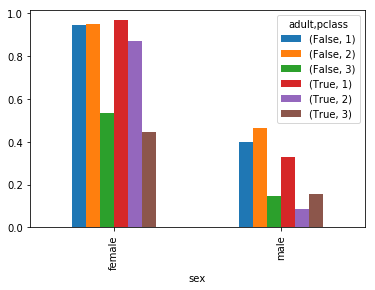

In [24]:
survivors_cube.plot.bar()

Notice that the $x$-axis of the bar graph contains all of the dimensions in the row index. So to get `pclass` on the $x$-axis, we have to create a pivot table where `pclass` is the row index:

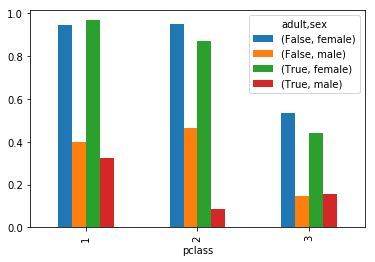

In [25]:
titanic_df.pivot_table(
    index="pclass", columns=["adult", "sex"],
    values="survived", aggfunc=np.mean
).plot.bar()

Finally, many analytical operations are easier to do when the data is in data cube format. We explore some of them in Section 2.4.

# Exercises

Exercises 1-2 deal with the Tips data set (`https://raw.githubusercontent.com/dlsun/data-science-book/master/data/tips.csv`).

**Exercise 1.** Calculate the average total bill by day, time, and table size. Display the results in a pivot table.

In [29]:
tips_df = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/tips.csv")
tips_df.pivot_table(
    index=["day", "time"], columns="size",
    values="total_bill", aggfunc=np.mean)

size             1          2          3          4      5          6
day  time                                                            
Fri  Dinner    NaN  17.799091        NaN  40.170000    NaN        NaN
     Lunch    8.58  13.072000  15.980000        NaN    NaN        NaN
Sat  Dinner   5.16  16.837170  25.509444  29.876154  28.15        NaN
Sun  Dinner    NaN  17.560000  22.184000  26.688333  27.00  48.170000
Thur Dinner    NaN  18.780000        NaN        NaN    NaN        NaN
     Lunch   10.07  15.079787  19.160000  29.950000  41.19  30.383333

**Exercise 2.** Make a bar chart showing the average total bill by table size, day, and time. (You will have to decide which variable(s) to represent on the $x$-axis and which variable(s) to represent using different colored bars.)

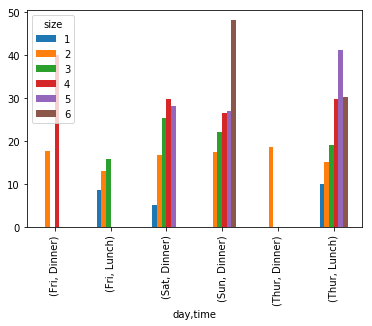

In [30]:
tips_df.pivot_table(
    index=["day", "time"], columns="size",
    values="total_bill", aggfunc=np.mean).plot.bar()

Exercises 3-4 deal with the Ames Housing data set (`https://raw.githubusercontent.com/dlsun/data-science-book/master/data/AmesHousing.txt`). For more information about the variables in this data set, please refer to the [data documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt).

**Exercise 3.** Calculate the average house price by neighborhood and building type, and store it in data cube form. Use the data cube to determine the neighborhood with the most expensive single-family homes.

In [49]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/dlsun/data-science-book/master/data/AmesHousing.txt",
    sep="\t")
df.head()

ames_cube = df.pivot_table(
    index="Neighborhood", columns="Bldg Type",
    values="SalePrice", aggfunc=np.mean)
print(ames_cube)

ames_cube.idxmax()

Bldg Type              1Fam         2fmCon         Duplex          Twnhs  \
Neighborhood                                                               
Blmngtn       177689.000000            NaN            NaN            NaN   
Blueste                 NaN            NaN            NaN  125480.000000   
BrDale                  NaN            NaN            NaN  103927.083333   
BrkSide       124779.952830  123500.000000            NaN            NaN   
ClearCr       210063.534884            NaN            NaN  148400.000000   
CollgCr       204901.450593            NaN  185000.000000            NaN   
Crawfor       199974.390805  148500.000000  177500.000000            NaN   
Edwards       132198.835443  106380.000000  120683.333333  132875.000000   
Gilbert       191145.306748  150000.000000            NaN            NaN   
Greens                  NaN            NaN            NaN  194500.000000   
GrnHill                 NaN            NaN            NaN            NaN   
IDOTRR      

Bldg Type
1Fam      StoneBr
2fmCon     Timber
Duplex    CollgCr
Twnhs      Greens
TwnhsE    Crawfor
dtype: object

**Exercise 4.** In the data cube above, there were many NaN values. Why is that? How is this a potential downside of the data cube format?

The 'NaN' values are placed there by pandas, because there does not exist an actual data point that fits in the criteria for that point (i.e Twin House in Clear Creek).